In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [ ]:
import pandas as pd
import cupy as cp

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from time import time

In [ ]:
''' let's generate synthetic data with scikit-learn '''
number_of_samples = 1_000_000
number_of_features = 10
number_of_clusters = 5
random_state = 41
n_init = 10
X, _ = make_blobs(n_samples=number_of_samples,
                  n_features=number_of_features,
                  centers=number_of_clusters,
                  random_state=random_state)

In [ ]:
X.shape

(1000000, 10)

In [ ]:
X_gpu = cp.asarray(X)

In [ ]:
X_gpu

array([[-3.26439558,  3.38463091, -3.76680012, ...,  8.06952921,
        -5.01839665, -5.66178287],
       [-8.3572317 , -6.14409828, -3.67550974, ...,  8.12756904,
         5.62321177, -6.12367454],
       [-2.89317085, -4.87385948, -6.86826383, ..., -3.06605679,
         3.92098742, -2.83897293],
       ...,
       [-1.87201078,  4.82677177, -2.98013783, ...,  8.52426773,
        -6.58244343, -5.32758663],
       [-3.68937718,  2.14368168, -3.63570224, ...,  8.36966772,
        -8.1496741 , -4.01754107],
       [-4.51996276, -8.37349743,  4.51958641, ...,  3.1467365 ,
         8.69647011, -2.79942792]])

In [ ]:
# generate synthetic data with cupy
X_cupy = cp.random.rand(number_of_samples, number_of_features)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = number_of_clusters, random_state = random_state, n_init=n_init)
kmeans.fit(X_gpu)

KMeans(n_clusters=5, n_init=10, random_state=41)

In [ ]:
cluster_centers = cp.asnumpy(kmeans.cluster_centers_)
inertia = kmeans.inertia_
cluster_centers, inertia

(array([[-3.0678431 ,  4.43368097, -2.9184719 , -0.78699986, -5.11117528,
         -4.3449413 ,  6.52780139,  7.48689147, -7.14147891, -4.39576663],
        [-8.33687094, -7.47581435, -3.53962107,  2.86027439,  9.99051294,
         -4.37778725,  1.64600555,  7.45425407,  5.78772825, -5.63721862],
        [-4.98157887, -9.07866843,  3.53486828, -9.13394775, -7.67172997,
          2.07994261, -6.18455812,  3.37397752,  8.34800929, -1.62348994],
        [-3.35368176, -4.34037487, -6.27671702, -3.65463389, -0.37581845,
         -8.60946983,  4.09911402, -3.70982181,  4.90323815, -2.03764069],
        [ 2.16668615,  4.57024273, -1.56536227, -2.12006694, -5.35532929,
         -1.16801347, -2.5361688 ,  1.6715147 , -7.99739057,  4.82335267]]),
 10003134.919117846)

In [ ]:
import matplotlib.pyplot as plt
cluster_range = range(1, 11)
wcss = []
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=random_state, n_init=n_init)
    kmeans.fit(X_gpu)
    wcss.append(kmeans.inertia_)

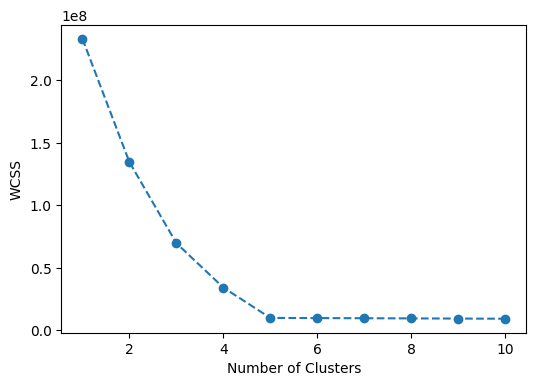

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(cluster_range, wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

U-Map

In [ ]:
import plotly.express as px
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [ ]:
data, labels = make_blobs(n_samples=number_of_samples,
                          n_features=number_of_features,
                          centers=number_of_clusters,
                          random_state=random_state)

data_gpu = cp.asarray(data)

In [ ]:
kmeans = KMeans(n_clusters=number_of_clusters, random_state=random_state, n_init=n_init)
kmeans.fit(data_gpu)

KMeans(n_clusters=5, n_init=10, random_state=41)

In [ ]:
cluster_labels = kmeans.labels_
cluster_labels

array([4, 1, 3, ..., 4, 4, 2], dtype=int32)

In [ ]:
umap3d = UMAP(n_neighbors=15, n_components=3, min_dist=0.1, random_state=random_state)
embedding3d = umap3d.fit_transform(data_gpu)

build_algo set to brute_force_knn because random_state is given


In [ ]:
embedding3d_cpu = cp.asnumpy(embedding3d)
cluster_labels_cpu = cp.asnumpy(cluster_labels)
fig = px.scatter_3d(x=embedding3d_cpu[:, 0],
                    y=embedding3d_cpu[:, 1],
                    z=embedding3d_cpu[:, 2],
                    color=cluster_labels_cpu.astype(str),
                    title='UMAP 3D Visualization of Synthetic Data')


fig.show()

In [ ]:
fig.update_traces(marker=dict(size=3))
fig.update_layout(
    scene=dict(
      xaxis_title='x',
      yaxis_title='y',
      zaxis_title='z',
      aspectmode='data'),
    margin=dict(l=0, r=0, b=0, t=40) )

fig.show()

Part II